# Joint evaluation in scenario B
Evaluation of the best variants of each models in scenario B; inspection of the result on various MW - weight of measured compound

In [1]:
base = "data"
dataset = "nist"
probs = [0, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5]

%load_ext autoreload
%autoreload 2

In [2]:
kind = "de_novo"
P_FOLDER = f"predictions/{kind}"

In [3]:
import numpy as np
from model_evaluation import model_selection, model_selection_random
from visual_utils import plot_scores
from data_utils import spectrum_processing
from matchms.importing import load_from_msp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def get_spectra(path):
    # Load data from MSP file and apply filters
    spectrums = [spectrum_processing(s, min_rel_int=None) for s in load_from_msp(path)]
    # Omit spectrums that didn't qualify for analysis
    spectrums = [s for s in spectrums if s is not None]
    # Create spectrum documents
    return spectrums
spectrums_test = get_spectra(f"{base}/{dataset}/{kind}/test.msp")

## Evaluation on all

## low

In [5]:
_, scores_knn = model_selection(P_FOLDER, "spec_test", kw="specknn_3", up_to_k=30, \
                                      l=4, j=6, to_rel_inten=.2, l_rel=None)

specknn_3
Possible k up to 30, predict up to 20 peaks
Selected up to k=30, l=4, j=6
Selected up to k=30, l=None, to_rel_inten=0.2
[25765 27551 27865 27893 27906 27908 27907 27902 27907 27851 27805 27771
 27719 27635 27546 27494 27414 27327 27246 27164 27067 26956 26858 26747
 26612 26502 26364 26238 26101 25961]


In [6]:
_, scores_lstm = model_selection(P_FOLDER, "gen_test", kw="elstm_unfreeze_intens_dst", up_to_k=30, \
                                      l=4, j=6, to_rel_inten=.2, l_rel=None)

elstm_unfreeze_intens_dst
Possible k up to 30, predict up to 20 peaks
Selected up to k=30, l=4, j=6
Selected up to k=30, l=None, to_rel_inten=0.2
[25765 27551 27865 27893 27906 27908 27907 27902 27907 27851 27805 27771
 27719 27635 27546 27494 27414 27327 27246 27164 27067 26956 26858 26747
 26612 26502 26364 26238 26101 25961]


In [7]:
_, scores_gpt = model_selection(P_FOLDER, "hugg_test", kw="gpt2_h6l6", up_to_k=30, \
                                      l=4, j=6, to_rel_inten=.2, l_rel=None, return_details=True)

gpt2_h6l6_auto
Possible k up to 30, predict up to 20 peaks
Selected up to k=30, l=4, j=6
Selected up to k=30, l=None, to_rel_inten=0.2
skipped spectrum - unknown peak
[25764 27550 27864 27892 27905 27907 27906 27901 27906 27850 27804 27770
 27718 27634 27545 27493 27413 27326 27245 27163 27066 26955 26857 26746
 26611 26501 26363 26237 26100 25960]


In [8]:
scores_test = {**scores_knn, **scores_gpt, **scores_lstm}

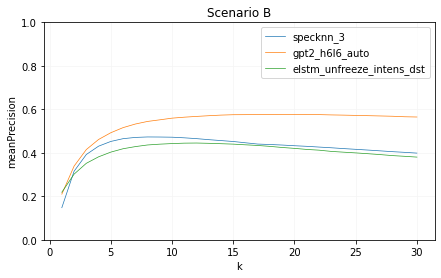

In [17]:
orderer_f = lambda x: x.split("_")[1]
hue_f = lambda x: ["specknn", "gpt2","elstm"].index(x.split("_")[0])
plot_scores(scores_test, metrics="mpi",
            orderer_f=orderer_f,hue_f=hue_f,
            title= "Scenario B" if kind=="de_novo" else "Scenario A",
            xlabel= "k", ylabel="meanPrecision", y_max=1,
            save_to_path=f"figures/{kind}/evaluation/topk.pdf")

### per MW
Show the precision individually per MW for fixed k

In [48]:
# get test MWs
Mws = [int(spec.metadata["mw"]) for spec in spectrums_test]
precs_gpt = scores_gpt["gpt2_h6l6_auto"]["precs"][4]

In [58]:
prec_per_MW = pd.DataFrame({"MW": Mws, "precs": precs_gpt}).groupby("MW").mean()
counts_per_MW = pd.DataFrame({"MW": Mws, "precs": precs_gpt}).groupby("MW").size()
x_lim = 700

<AxesSubplot:xlabel='MW'>

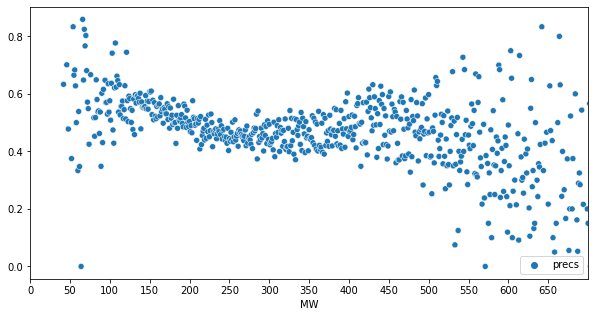

In [76]:
plt.figure(figsize=(10,5))
plt.xticks(np.arange(0, x_lim, 50))
plt.xlim(0, x_lim)
sns.scatterplot(data=prec_per_MW)

<AxesSubplot:ylabel='Count'>

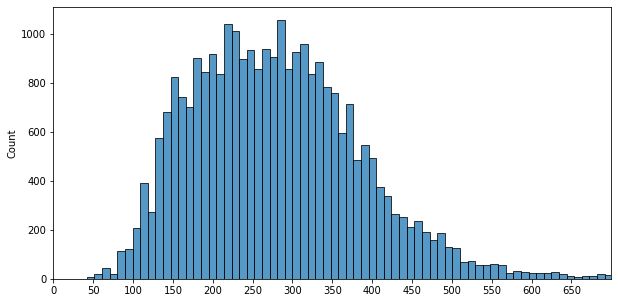

In [75]:
plt.figure(figsize=(10,5))
plt.xticks(np.arange(0, x_lim, 50))
plt.xlim(0, x_lim)
sns.histplot(Mws)

### Random

In [18]:
_, scores_random_knn = model_selection_random(P_FOLDER, "spec_test", \
                                                  kw="specknnR_3_.5" )


specknnR_3_.5


/auto/brno6/home/xstary1/raims/metrics.py:232: RuntimeWarning: Mean of empty slice
  
/auto/brno6/home/xstary1/raims/metrics.py:234: RuntimeWarning: Mean of empty slice
  if up_to_k is None:
/auto/brno6/home/xstary1/raims/metrics.py:235: RuntimeWarning: Mean of empty slice
  up_to_k = len(l_pred_indices_per_k)


In [19]:
_, scores_random_lr = model_selection_random(P_FOLDER, "fixed_test", \
                                                  kw="linear")

linear_.1


In [20]:
_, scores_random_mlp = model_selection_random(P_FOLDER, "fixed_test", \
                                                  kw="mlp" )

mlp_3_.3


In [21]:
scores_random_test = {**scores_random_knn,
                        **scores_random_lr,
                        **scores_random_mlp}

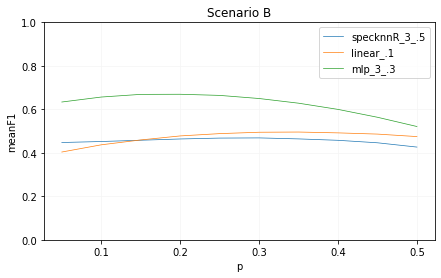

In [22]:
orderer_f = lambda x: x[2]
# hue_f = lambda x: [".5",".8","1","1.2"].index(x.split("_")[2])
plot_scores(scores_random_test, metrics="mf1", x=probs,
            orderer_f=orderer_f,hue_f=None,
            title= "Scenario B" if kind=="de_novo" else "Scenario A",
            xlabel= "p", ylabel="meanF1", y_max=1,
            save_to_path=f"figures/{kind}/evaluation/random.pdf")